# Hierarchical Partial-Order (HPO) Model Simulation

This document provides a comprehensive guide to simulating data from a **Hierarchical Partial-Order (HPO) Model**. The HPO model is designed to generate hierarchical structures of partial orders based on latent variables influenced by multiple assessors. This simulation accounts for global latent scores, assessor-specific deviations, and observed ranking data within specified choice sets.

In [1]:
# ───────────────────────────────────────────────────────────────
#  Bootstrap: add project root AND ensure src/ is a package
# ───────────────────────────────────────────────────────────────
import os, sys, pkgutil
from pathlib import Path

# 1) paths
current_dir  = Path.cwd()           # /…/hpo_inference/hpo_inference/notebooks
project_root = current_dir.parents[0]   # /…/hpo_inference
src_dir      = project_root / "src"
utils_dir    = src_dir / "utils"
data_dir      = project_root / "data"


# 2) make sure __init__.py files exist
for d in (src_dir, utils_dir):
    d.mkdir(parents=True, exist_ok=True)
    init_file = d / "__init__.py"
    if not init_file.exists():
        init_file.touch()           # empty file is fine

# 3) add to sys.path once
project_root_str = str(project_root)
if project_root_str not in sys.path:
    sys.path.insert(0, project_root_str)

print("✅ Current dir :", current_dir)
print("✅ Project root in PYTHONPATH :", project_root_str)
print("✅ src package found? ->", pkgutil.find_loader("src") is not None)

# 4) now the project‑specific imports
from src.utils.po_fun           import BasicUtils, StatisticalUtils, GenerationUtils
from src.utils.po_fun_plot      import PO_plot
from src.utils.po_accelerator_nle import LogLikelihoodCache, HPO_LogLikelihoodCache
from src.mcmc.hpo_po_hm_mcmc_k  import mcmc_simulation_hpo_k
from src.mcmc.hpo_po_hm_mcmc   import mcmc_simulation_hpo


# 3) Standard libraries
import math
import random
import itertools
from collections import Counter, defaultdict
from typing import List, Dict, Any, Optional

# 4) Third‑party libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
from scipy.stats import multivariate_normal, norm, beta

# 5) load config
import yaml, pprint
config_path = project_root / "config" / "hpo_mcmc_configuration.yaml"
with open(config_path) as f:
    config = yaml.safe_load(f)

print("✅ Configuration loaded, top‑level keys:", list(config.keys())[:10])


✅ Current dir : /home/doli/Desktop/research/coding/hpo_inference/notebooks
✅ Project root in PYTHONPATH : /home/doli/Desktop/research/coding/hpo_inference
✅ src package found? -> True
✅ Configuration loaded, top‑level keys: ['sampling', 'mcmc', 'reversible_two_factors', 'rho', 'rhotau', 'beta', 'noise', 'prior']


## HPO Data Generation

In [2]:
data_file = data_dir / "item_characteristics.csv"
# Read the items section (first part of the CSV)
items_df = pd.read_csv(data_file, nrows=6)

# Count distinct item IDs
n = len(items_df['item_id'].unique())
print(f"Number of distinct items in the HPO data: n = {n}")

# Read the assessors section (skip items and blank line)
assessors_df = pd.read_csv(data_file, skiprows=12, nrows=5)
assessors = assessors_df['assessor_id'].tolist()
print(f"Assessors in the HPO data: assessors = {assessors}")

# read the covariates 
covariate_cols = [col for col in items_df.columns if col.startswith('covariate_')]
X_values = items_df[covariate_cols].values

X = X_values.T  # Features in rows, items in columns

print(X)
p = X.shape[0]

Number of distinct items in the HPO data: n = 6
Assessors in the HPO data: assessors = [1, 2, 3, 4, 5]
[[ 0.37802569  0.48863089 -0.15577621 -0.44536924 -1.8669192   0.55245804]
 [-1.01646298  0.47438509  0.01097829 -0.52150505 -0.40398393  0.47443509]
 [ 0.14047358  2.25298144 -1.63119938  1.02517382  0.05745798  1.12308145]
 [-0.13616264  0.47518221  0.68298665 -1.50720735  0.74654455  1.0137161 ]
 [-1.01137608  0.52092759 -0.29971271  1.59843582  0.61110338 -0.09988741]]


### Construct U_0 and U_a priors
1. construct U_0 and U_a priors from the given prior 
2. given the h(U_0) and h(U_a) sampling the observed orders for each assessor

In [3]:
# First let's give a U0 , to sample U0 we need the rho, and the number of nodes
#K_prior=config["prior"]["k_prior"]
rho_prior = config["prior"]["rho_prior"]
noise_option = config["noise"]["noise_option"]
sigma_beta = config["prior"]["sigma_beta"]  # Standard deviation of the normal distribution for beta
rng = np.random.default_rng(42)
beta_true =rng.normal(loc=0.0, scale=sigma_beta, size=(p,))
tau_true = StatisticalUtils.rTauprior() 
rho_true=beta.rvs(1,rho_prior)
#K=StatisticalUtils.rKprior(K_prior) 
K=config["mcmc"]["K"]
K_true=K

noise_beta_prior = config["prior"]["noise_beta_prior"] 
prob_noise_true = StatisticalUtils.rPprior(noise_beta_prior)
print("prob niose is:")
print(prob_noise_true)


print("Tau true is: ") 
print(tau_true)
print("K true is: ")
print(K_true)


prob niose is:
0.0453482742611421
Tau true is: 
0.8405025371213917
K true is: 
3


In [4]:
alpha = X.T @ beta_true  
print("\n The covariates effects (alpha):")
print(alpha)


 The covariates effects (alpha):
[ 3.12287534  0.7768854  -0.05587726 -3.36024232 -0.59573663  1.66610571]


### Ma generation:
The subset is generated by the following code 

In [5]:
#now we generate the subset 

# Generate selection lists Ma for each order
items = list(range(n))
item_to_index = {item: idx for idx, item in enumerate(items)}
index_to_item = {idx: item for idx, item in enumerate(items)}
M_a_list= GenerationUtils.generate_subsets(len(assessors), n) 
# We further sort the subsets 
M_a_dict = {a: sorted(subset) for a, subset in zip(assessors, M_a_list)}



### Generate HPO:

In [6]:
##Generate U_0 
U_global = GenerationUtils.generate_U(n, K_true, rho_true)


## Construct the Ua_dict: 
U_a_dict = {}  # We'll store U^(a) in a dictionary keyed by assessor ID

index_to_item_local_dict = {
    a: {i: item for i, item in enumerate(M_a_dict[a])}
    for a in assessors
}

for idx_a, a in enumerate(assessors):
    Ma = M_a_list[idx_a]
    n_a = len(Ma)
    Ua = np.zeros((n_a, K), dtype=float)

    # For each item j in M_a, sample from N(tau_true * U_global[j], (1 - tau_true^2)*I)
    for i_loc, j_global in enumerate(Ma):        
        mean_vec = tau_true * U_global[j_global, :]
        Sigma=BasicUtils.build_Sigma_rho(K, rho_true)
        cov_mat = (1.0 - tau_true**2) * Sigma
        Ua[i_loc, :] = np.random.multivariate_normal(mean=mean_vec, cov=cov_mat)

    U_a_dict[a] = Ua

# Transform the U to H given the partial order definition
h_U_dict = StatisticalUtils.build_hierarchical_partial_orders(
    M0=items,
    assessors=assessors,
    M_a_dict=M_a_dict, 
    U0=U_global,
    U_a_dict=U_a_dict,
    alpha=alpha,
    link_inv=None
)

The global partial order matrix is:
[[0 0 0 0 0 1]
 [0 0 1 0 0 0]
 [0 0 0 0 1 0]
 [0 0 0 0 0 0]
 [0 0 0 1 0 0]
 [0 1 0 0 0 0]]
Assessor 1 has partial order matrix:
[2, 3]
[[0 1]
 [0 0]]
Assessor 2 has partial order matrix:
[0, 1, 2, 3, 4, 5]
[[0 0 0 0 0 1]
 [0 0 1 0 1 0]
 [0 0 0 1 0 0]
 [0 0 0 0 0 0]
 [0 0 0 1 0 0]
 [0 1 0 0 0 0]]
Assessor 3 has partial order matrix:
[3, 4, 5]
[[0 0 0]
 [1 0 0]
 [0 1 0]]
Assessor 4 has partial order matrix:
[0, 1, 2, 3, 5]
[[0 0 0 0 1]
 [0 0 1 0 0]
 [0 0 0 1 0]
 [0 0 0 0 0]
 [0 1 0 0 0]]
Assessor 5 has partial order matrix:
[2, 3, 4]
[[0 0 1]
 [0 0 0]
 [0 1 0]]


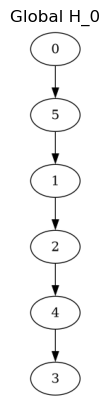

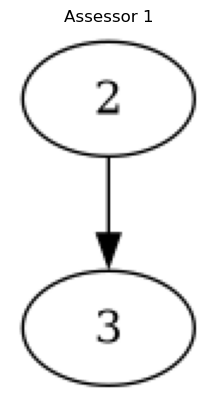

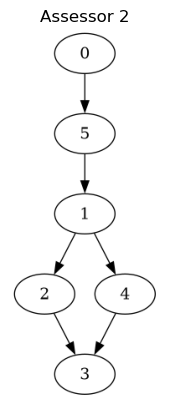

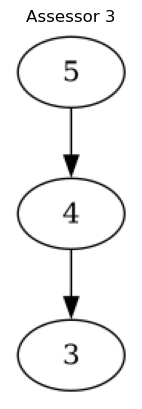

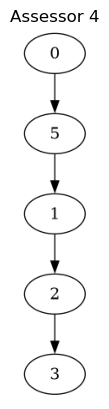

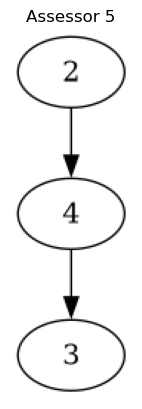

In [7]:
## Visualise the partial order matrix
for i in range(0,len(assessors)):
    if i==0:
        print(f"The global partial order matrix is:")
        print(BasicUtils.transitive_reduction(h_U_dict[0]))
        PO_plot.visualize_partial_order(BasicUtils.transitive_reduction(h_U_dict[0]), items ,f"Global H_0")

    print(f"Assessor {assessors[i]} has partial order matrix:")
    print(M_a_dict.get(assessors[i]))
    print(BasicUtils.transitive_reduction(h_U_dict.get(assessors[i])))
    PO_plot.visualize_partial_order(BasicUtils.transitive_reduction(h_U_dict.get(assessors[i])), M_a_dict.get(assessors[i]), f"Assessor {assessors[i]}")

### Generate the total orders from the HPOs for each assessor:  

1. We set a random variable to generate at least the number of orders for the observation, assume the number of ordes to generate is apossion distributino with the number of nodes in each of the MA list
3. We need to generate the subsets first, for each subset, there will be a order based on the given h_and the subset
4. however  there is a queque jump issue when generating the obderved order. 

In [8]:
# Generate choice sets for each assessor from its Ma list:
min_tasks=config["sampling"]["min_tasks_scaler"]*n
min_size=config["sampling"]["min_size"]
O_a_i_dict = GenerationUtils.generate_choice_sets_for_assessors(M_a_dict, min_tasks=min_tasks, min_size= min_size)

# Print the result
for assessor, tasks in O_a_i_dict.items():
    print(f"Assessor {assessor}: {tasks}")

Assessor 1: [[2, 3], [2, 3], [2, 3], [2, 3], [2, 3], [2, 3], [2, 3], [2, 3], [2, 3], [2, 3], [2, 3], [2, 3], [2, 3], [2, 3], [2, 3], [2, 3]]
Assessor 2: [[0, 2, 3, 4, 5], [0, 1, 2, 3, 4, 5], [1, 4], [1, 3], [0, 3, 4], [0, 1, 2, 4, 5], [0, 1, 2, 3, 4, 5], [1, 3, 5], [0, 1, 2, 3, 4], [0, 4], [2, 4], [0, 1, 2, 3, 4, 5], [0, 1, 2, 3, 4], [0, 1, 2, 4, 5], [0, 1, 2, 3, 4, 5], [0, 2, 5], [0, 2, 3], [0, 1, 2], [0, 2, 3, 4, 5], [0, 2, 3, 4], [0, 3], [1, 2, 4], [0, 2, 3, 4, 5]]
Assessor 3: [[3, 5], [3, 4], [3, 5], [4, 5], [3, 4, 5], [3, 5], [3, 4, 5], [4, 5], [3, 4, 5], [3, 4, 5], [3, 4, 5], [3, 5], [3, 4, 5], [4, 5], [4, 5], [3, 4, 5], [3, 4, 5], [3, 4]]
Assessor 4: [[0, 1, 3, 5], [0, 3], [0, 1, 2, 3, 5], [0, 2, 3], [3, 5], [1, 3, 5], [1, 5], [0, 5], [0, 1, 5], [0, 1, 2, 5], [0, 2, 3, 5], [0, 1, 2, 5], [0, 5], [3, 5], [1, 3, 5], [0, 1, 2, 3], [0, 3, 5], [0, 2, 3, 5], [0, 3], [0, 1, 2, 3, 5], [0, 1, 2, 3, 5], [0, 1, 5], [0, 2, 3, 5], [0, 1, 2, 3, 5], [0, 1, 2, 3, 5], [0, 2, 5], [1, 2, 3], [3, 5]

In [9]:
y_a_i_dict = GenerationUtils.generate_total_orders_for_assessor(h_U_dict, M_a_dict,O_a_i_dict,prob_noise_true)

PO_plot.save_rankings_to_csv(y_a_i_dict, output_file='data/observed_rankings_no_k.csv')

Rankings saved to data/observed_rankings_no_k.csv


# MCMC with Hierarchical Partial Orders

In [10]:
num_iterations = config["mcmc"]["num_iterations"]   
dr = config["rho"]["dr"]
drbeta=config["beta"]["drbeta"]
drrt=config["rhotau"]["drrt"]
sigma_mallow = config["noise"]["sigma_mallow"]
noise_beta_prior = config["prior"]["noise_beta_prior"]
mallow_ua = config["prior"]["mallow_ua"]

mcmc_pt = [
    config["mcmc"]["update_probabilities"]["rho"],
    config["mcmc"]["update_probabilities"]["tau"],
    config["mcmc"]["update_probabilities"]["rho_tau"],
    config["mcmc"]["update_probabilities"]["noise"],
    config["mcmc"]["update_probabilities"]["U_0"],
    config["mcmc"]["update_probabilities"]["U_a"],
    config["mcmc"]["update_probabilities"]["beta"]
    ]

In [11]:

mcmc_results= mcmc_simulation_hpo(
        num_iterations=num_iterations,
        M0=items,
        assessors=assessors,
        M_a_dict=M_a_dict,
        O_a_i_dict=O_a_i_dict,
        observed_orders=y_a_i_dict,
        sigma_beta=sigma_beta,    
        X=X,  
        K=K,
        dr=dr,
        drrt=drrt,
        drbeta=drbeta,
        sigma_mallow=sigma_mallow,
        noise_option=noise_option,
        mcmc_pt=mcmc_pt,
        rho_prior=rho_prior,
        noise_beta_prior=noise_beta_prior,
        mallow_ua=mallow_ua,
        random_seed=42
)

/home/doli/Desktop/research/coding/hpo_inference/src/mcmc/hpo_po_hm_mcmc.py:340: RuntimeWarning: overflow encountered in exp
  if rng.random() < min(1.0, np.exp(log_acceptance_ratio)):


Iteration 50000/1000000 - Accept Rate: 40.60%
Iteration 100000/1000000 - Accept Rate: 41.55%
Iteration 150000/1000000 - Accept Rate: 41.58%
Iteration 200000/1000000 - Accept Rate: 41.29%
Iteration 250000/1000000 - Accept Rate: 41.10%
Iteration 300000/1000000 - Accept Rate: 41.30%
Iteration 350000/1000000 - Accept Rate: 41.47%
Iteration 400000/1000000 - Accept Rate: 41.42%
Iteration 450000/1000000 - Accept Rate: 41.33%
Iteration 500000/1000000 - Accept Rate: 41.06%
Iteration 550000/1000000 - Accept Rate: 40.99%
Iteration 600000/1000000 - Accept Rate: 40.93%
Iteration 650000/1000000 - Accept Rate: 40.96%
Iteration 700000/1000000 - Accept Rate: 40.99%
Iteration 750000/1000000 - Accept Rate: 41.15%
Iteration 800000/1000000 - Accept Rate: 41.06%
Iteration 850000/1000000 - Accept Rate: 41.13%
Iteration 900000/1000000 - Accept Rate: 41.21%
Iteration 950000/1000000 - Accept Rate: 41.13%
Iteration 1000000/1000000 - Accept Rate: 41.14%
Progress: [========================================] 100.0% 

## MCMC Result 

1. Choose the burn out period through the likelihood function:
2. Convert the adjacency matrix to a partial order

### MCMC result without reversible jump

Excluding 0 burn-in iterations


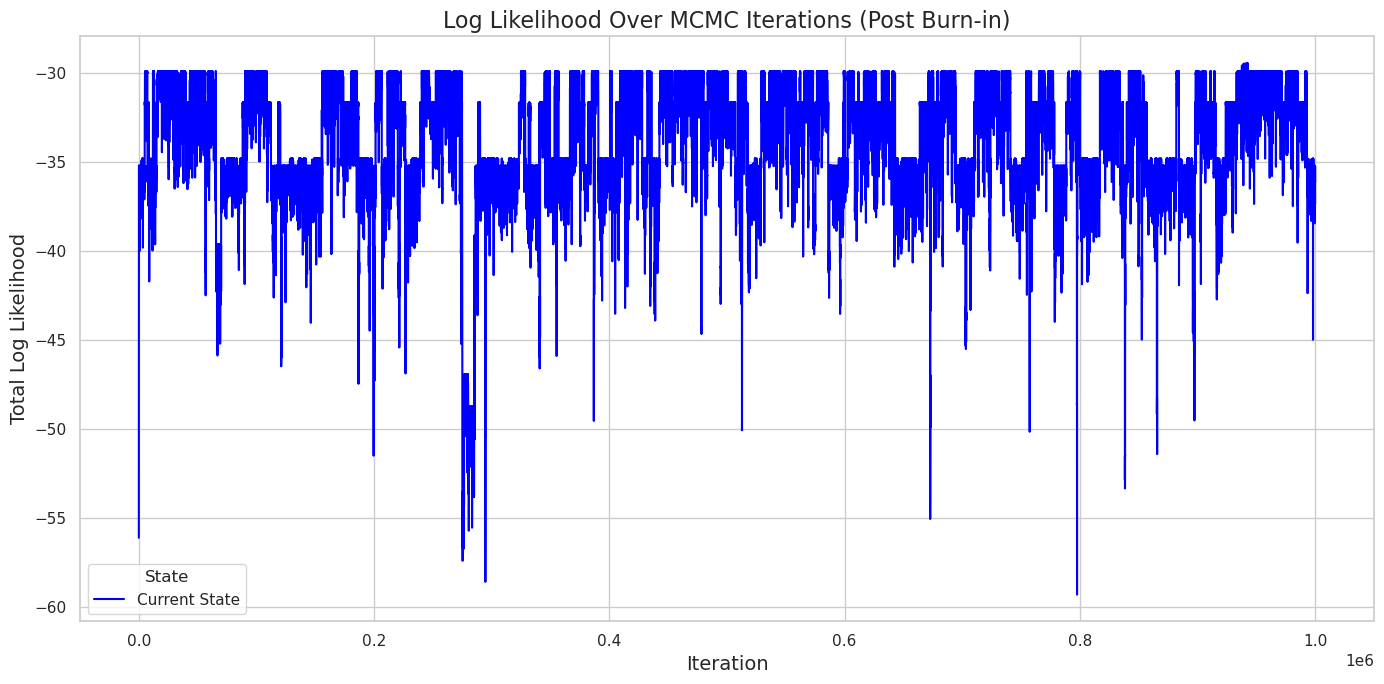

In [12]:
# Get log likelihood values from MCMC results
log_likelihood_currents = mcmc_results.get('log_likelihood_currents', [])
PO_plot.plot_log_likelihood(log_likelihood_currents,burn_in=0)

In [13]:
# Calculate burn-out index (assuming 100,000 total iterations and discarding the first 1%)
#mcmc_results=mcmc_results_k
h_trace= mcmc_results["H_trace"]
burn_in = int(10000/ 100)  # Convert to integer (1000 instead of 1000.0)
filtered_h_trace = h_trace[burn_in:]

filtered_mcmc_results = {
    key: trace[burn_in:] if isinstance(trace, np.ndarray) else trace
    for key, trace in mcmc_results.items()
}

Total number of samples in h_0: 9900



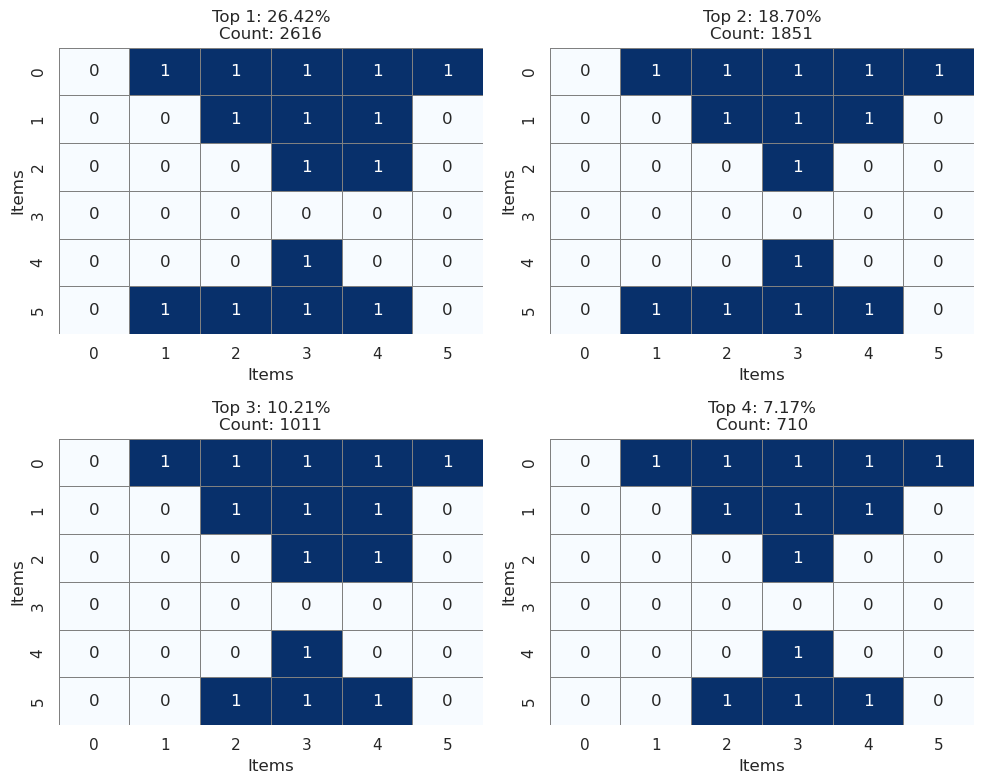

Total number of samples in h_1: 9900



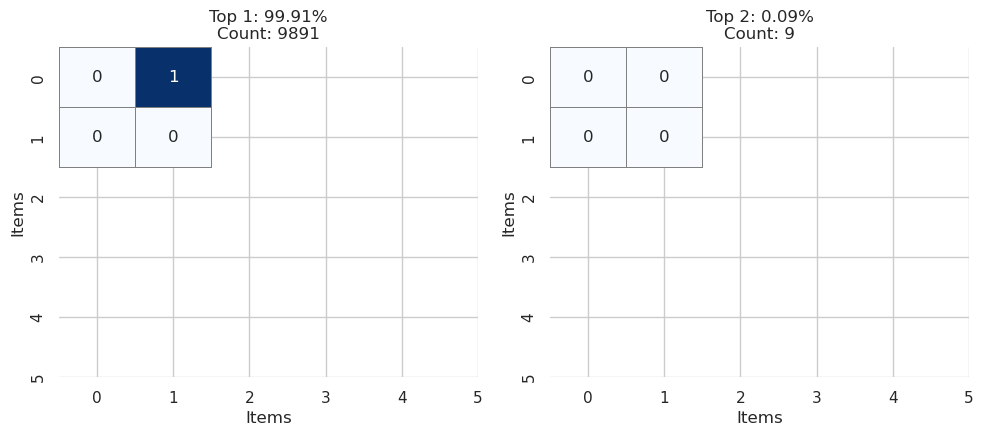

Total number of samples in h_2: 9900



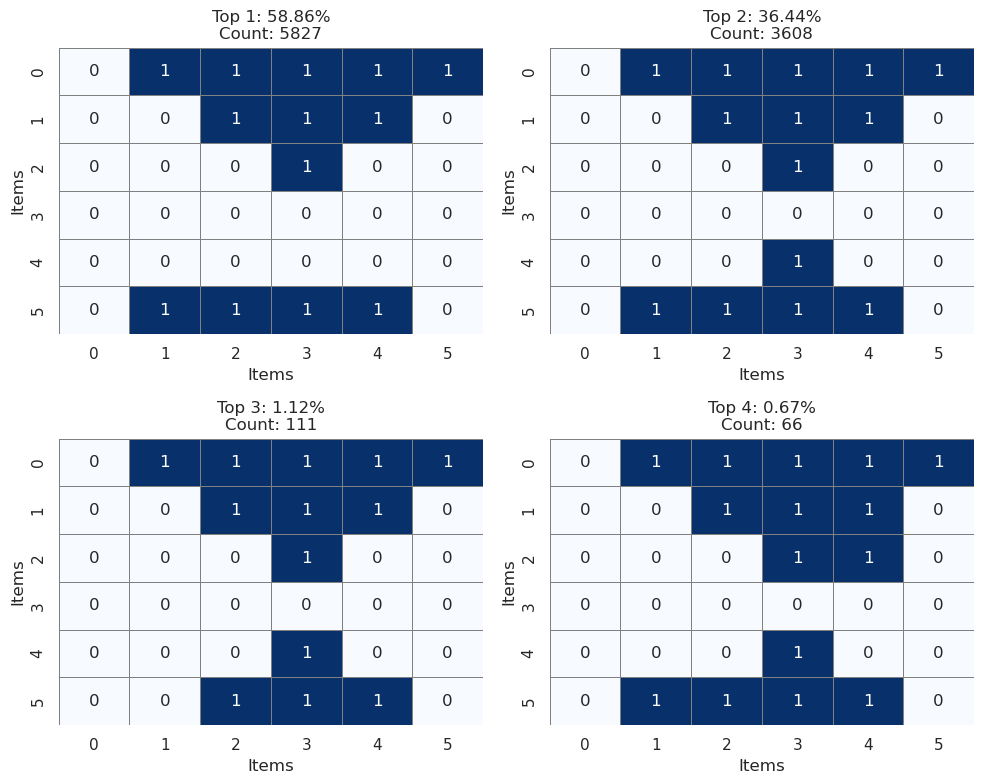

Total number of samples in h_3: 9900



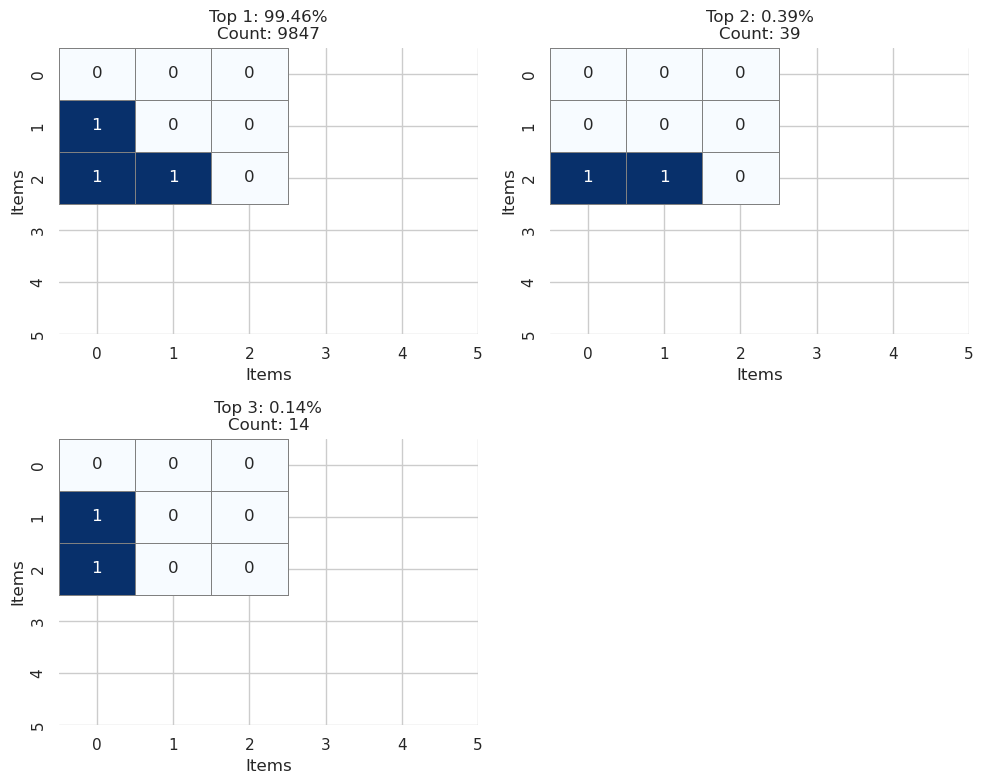

Total number of samples in h_4: 9900



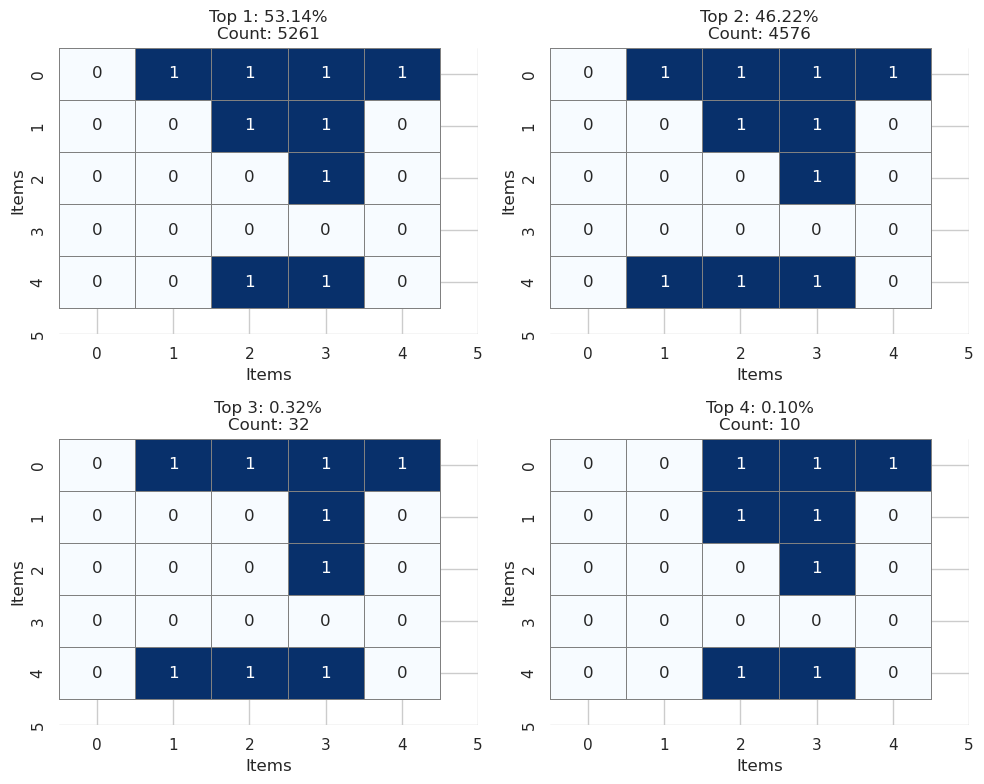

Total number of samples in h_5: 9900



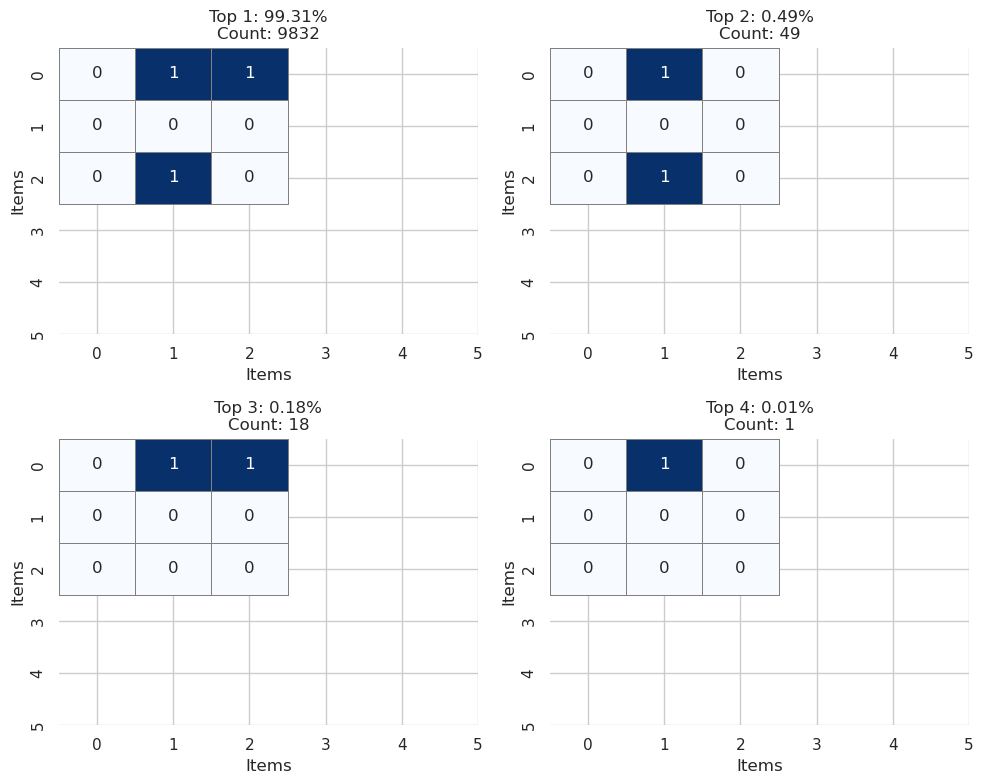

In [14]:
threshold = 0.5

# Create a new dictionary to store the final inferred binary partial orders.
final_H = {}
# Get all assessor IDs from the first iteration
assessor_ids = filtered_h_trace[0].keys()
for assessor in assessor_ids:
    # Collect the h matrix for this assessor from each iteration.
    matrices = [h_iter[assessor] for h_iter in filtered_h_trace  if assessor in h_iter]
    # Compute element-wise average.
    mean_matrix = np.mean(matrices, axis=0)
    sorted_matrix= StatisticalUtils.count_unique_partial_orders(matrices)
    total_samples = sum(count for _, count in sorted_matrix)
    print(f"Total number of samples in h_{assessor}: {total_samples}\n")
    top_n = 4
    top_partial_orders =sorted_matrix[:top_n]
    top_percentages = [(order, count, (count / total_samples) * 100) for order, count in top_partial_orders]
    PO_plot.plot_top_partial_orders(top_percentages, top_n=top_n, item_labels=items)


    # Threshold the matrix.
    binary_matrix = (mean_matrix >= threshold).astype(int)
    # Compute transitive reduction.
    h_final = BasicUtils.transitive_reduction(binary_matrix)
    final_H[assessor] = h_final


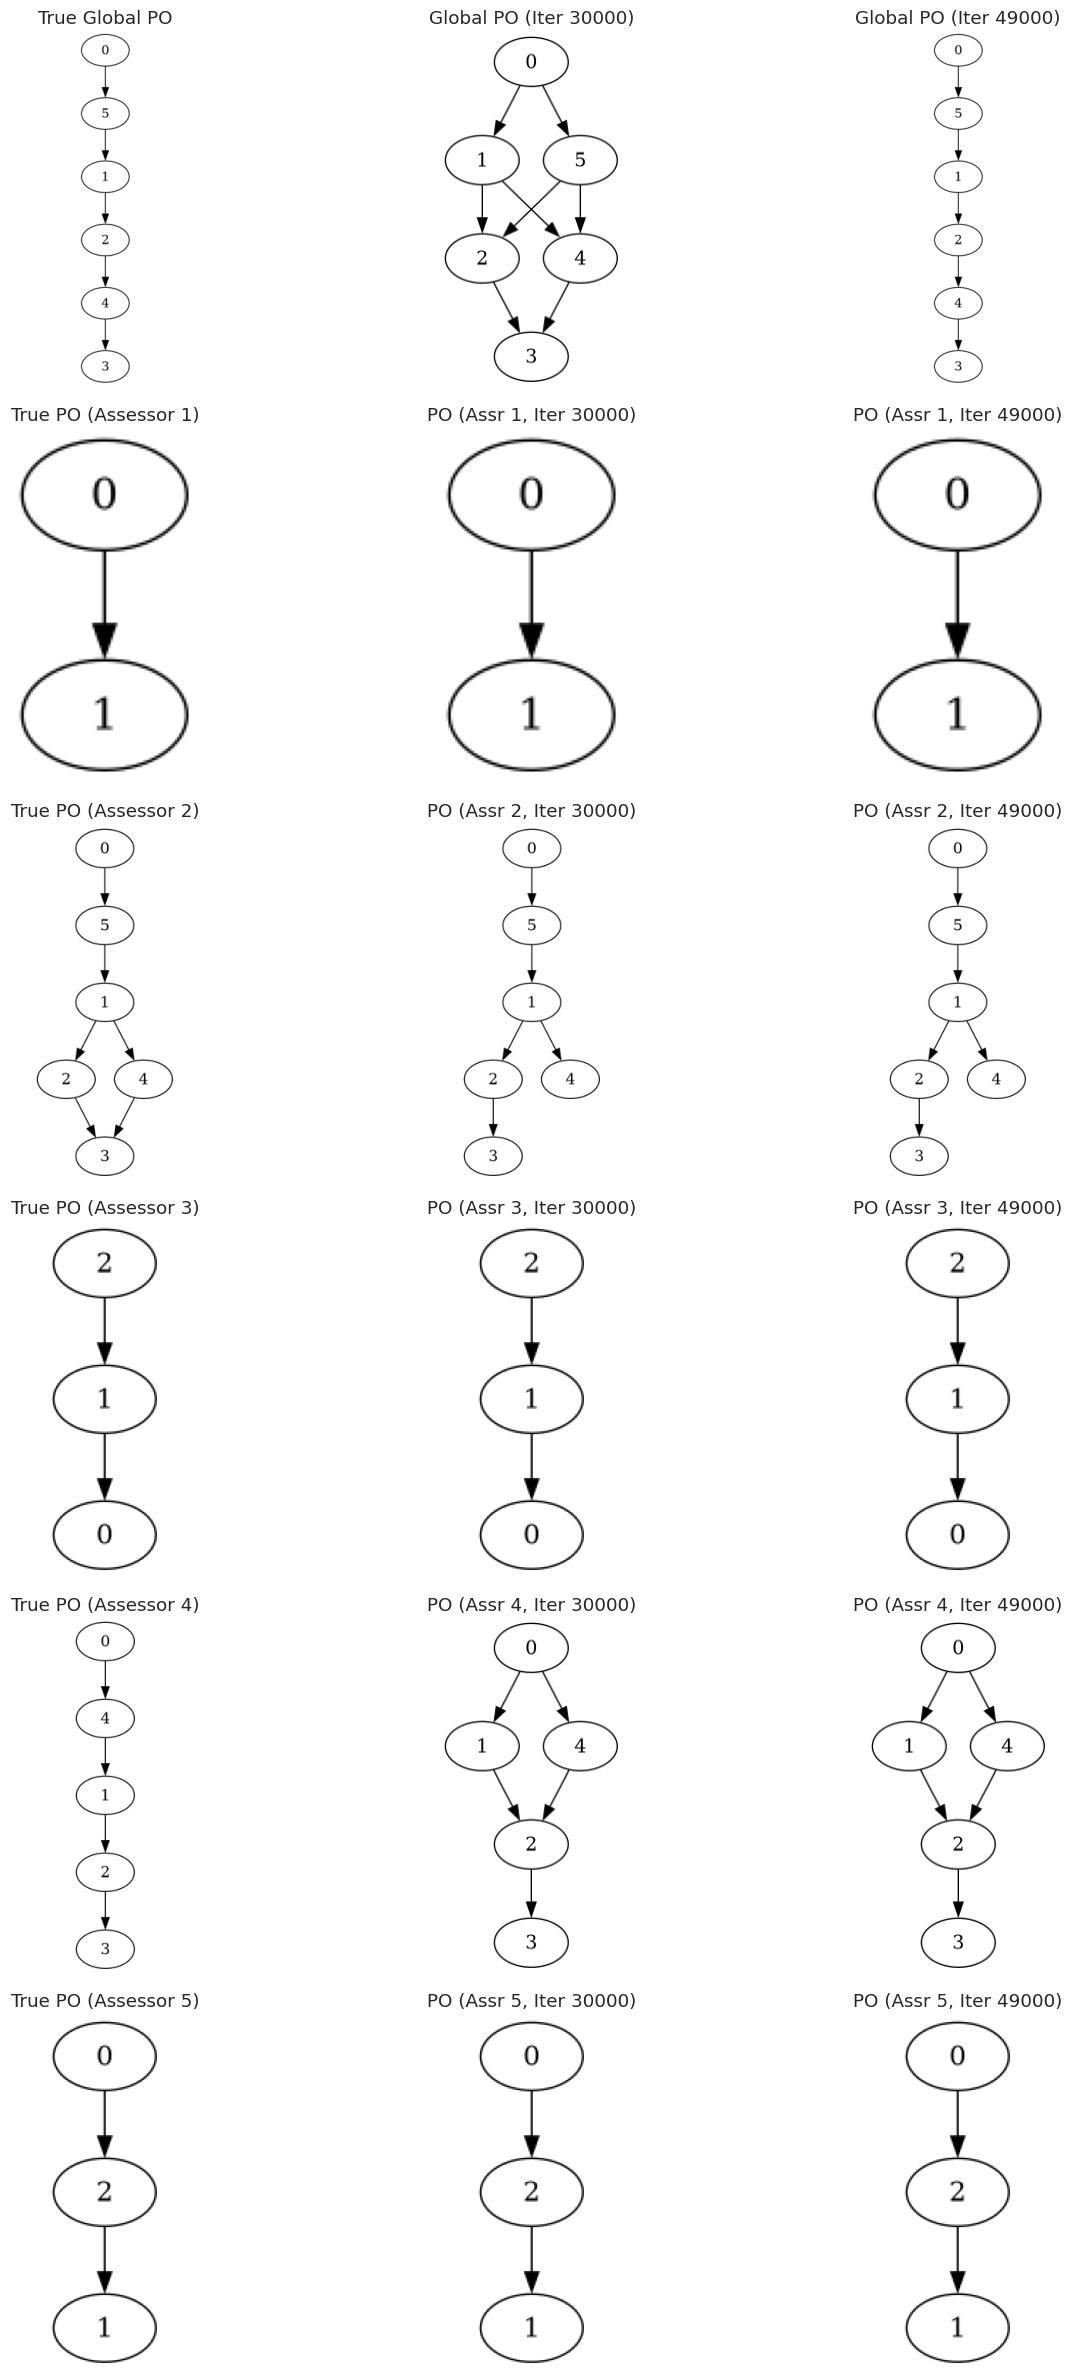


========== Comparison Output Summary ==========
Iterations: 30000 vs 49000

---- Iteration 1 Parameters ----
rho         = 0.6944162081252753
tau         = 0.7549725652149859
prob_noise  = 0.002982910115664372
mallow_theta= 0.08973803468138616
log-likelihood = -29.9488

---- Iteration 2 Parameters ----
rho         = 0.9022029474831389
tau         = 0.6991939943230767
prob_noise  = 0.006743861432498741
mallow_theta= 0.08973803468138616
log-likelihood = -30.7312

---- Iteration 1 Partial Orders (transitive-reduced) ----
Assessor 0, shape = (6, 6)
[[0 1 0 0 0 1]
 [0 0 1 0 1 0]
 [0 0 0 1 0 0]
 [0 0 0 0 0 0]
 [0 0 0 1 0 0]
 [0 0 1 0 1 0]]

Assessor 1, shape = (2, 2)
[[0 1]
 [0 0]]

Assessor 2, shape = (6, 6)
[[0 0 0 0 0 1]
 [0 0 1 0 1 0]
 [0 0 0 1 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 1 0 0 0 0]]

Assessor 3, shape = (3, 3)
[[0 0 0]
 [1 0 0]
 [0 1 0]]

Assessor 4, shape = (5, 5)
[[0 1 0 0 1]
 [0 0 1 0 0]
 [0 0 0 1 0]
 [0 0 0 0 0]
 [0 0 1 0 0]]

Assessor 5, shape = (3, 3)
[[0 0 1]
 [0 0 0]

In [23]:
result_dict = mcmc_results
# 2) Choose iteration indices for comparison
iterationA = 30000
iterationB =49000
threshold = 0.5

comparison_out = PO_plot.compare_two_mcmc_states(
    result_dict,            # pass as first positional argument
    h_U_dict,             # first positional argument
    iterationA,             # second positional argument
    iterationB,             # third positional argument
    threshold=threshold,    # remaining can be by keyword
    assessors=assessors,
    items=items,
    plot_partial_orders=True
)
PO_plot.print_comparison_summary(comparison_out)


## The acceptance decision plot for different category 



--- MCMC Update Acceptance Rates by Category ---
rho       : 23.78%
tau       : 15.41%
rho_tau   : 69.87%
K_dim     : No updates recorded.
beta      : 55.70%
noise     : 29.63%
U0        : 61.53%
Ua        : 35.61%


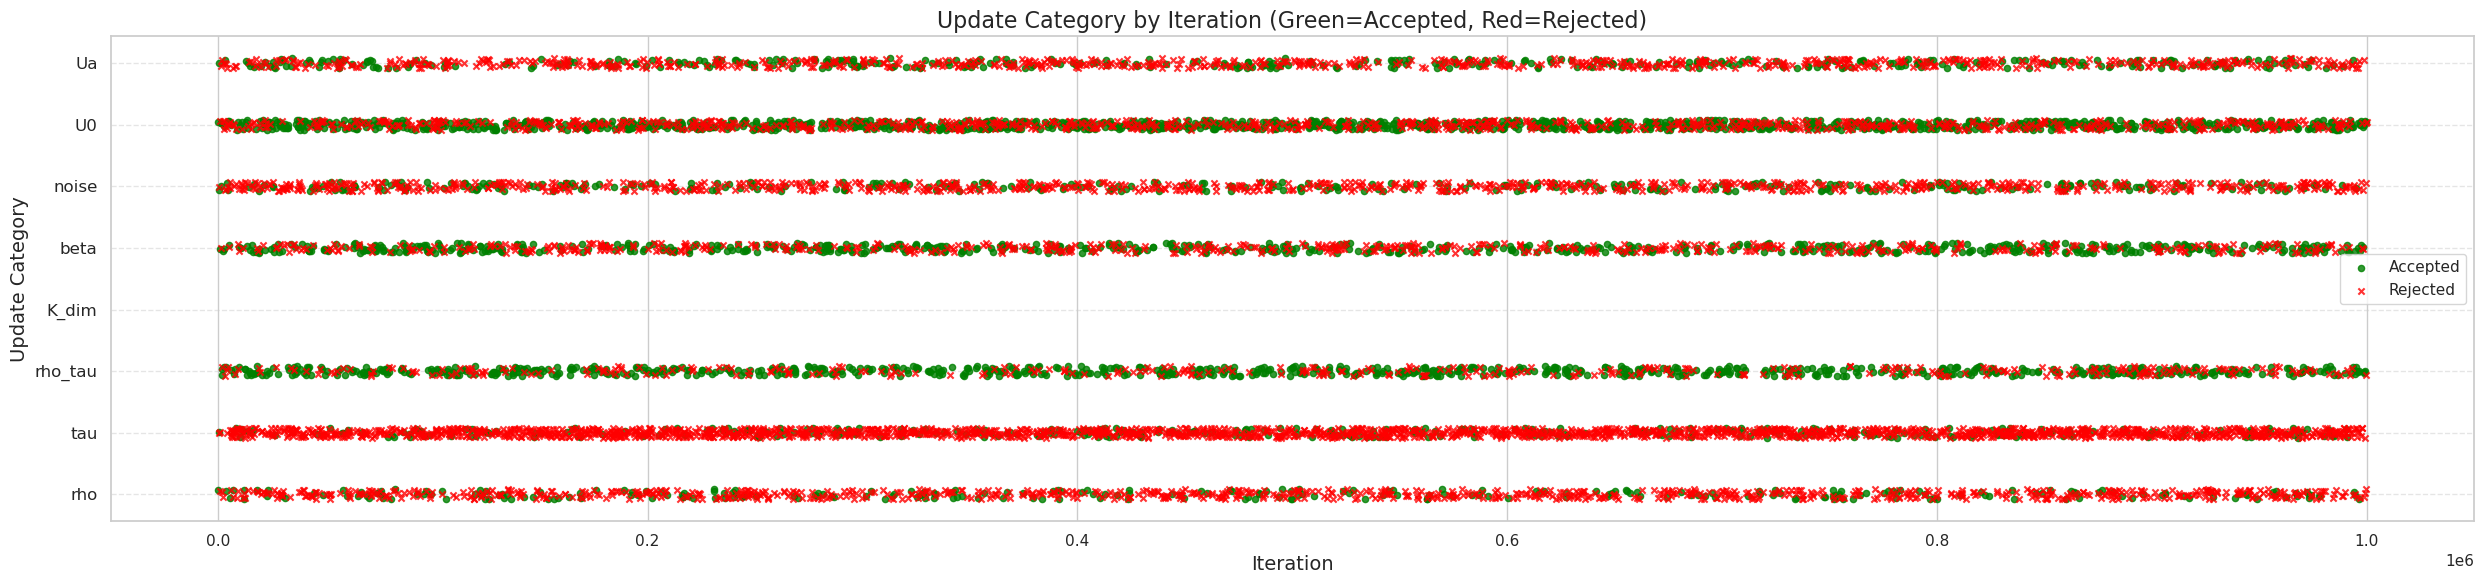

In [16]:
PO_plot.plot_update_acceptance_by_category(mcmc_results)

## The time analysis for the MCMC
1. We could observe that likelihood has taken a large proportion of the update 
2. The spike is because the H matrix has changed and we need to recalculate the linear extensions or the observed list is long, and else are drawn from the cache 
3. Note that we only apply the cache to the proposed calculation of likelihood, and we will apply cache to the prime calculation of likelihood to save more time 
4. Ua takes the most amount of time at the moment

In [17]:
mcmc_df = pd.DataFrame({
    "Iteration": mcmc_results["iteration_list"],
    "UpdateCategory": mcmc_results["update_category_list"],
    "PriorTime": mcmc_results["prior_timing_list"],
    "LikelihoodTime": mcmc_results["likelihood_timing_list"],
    "UpdateTime": mcmc_results["update_timing_list"]
})

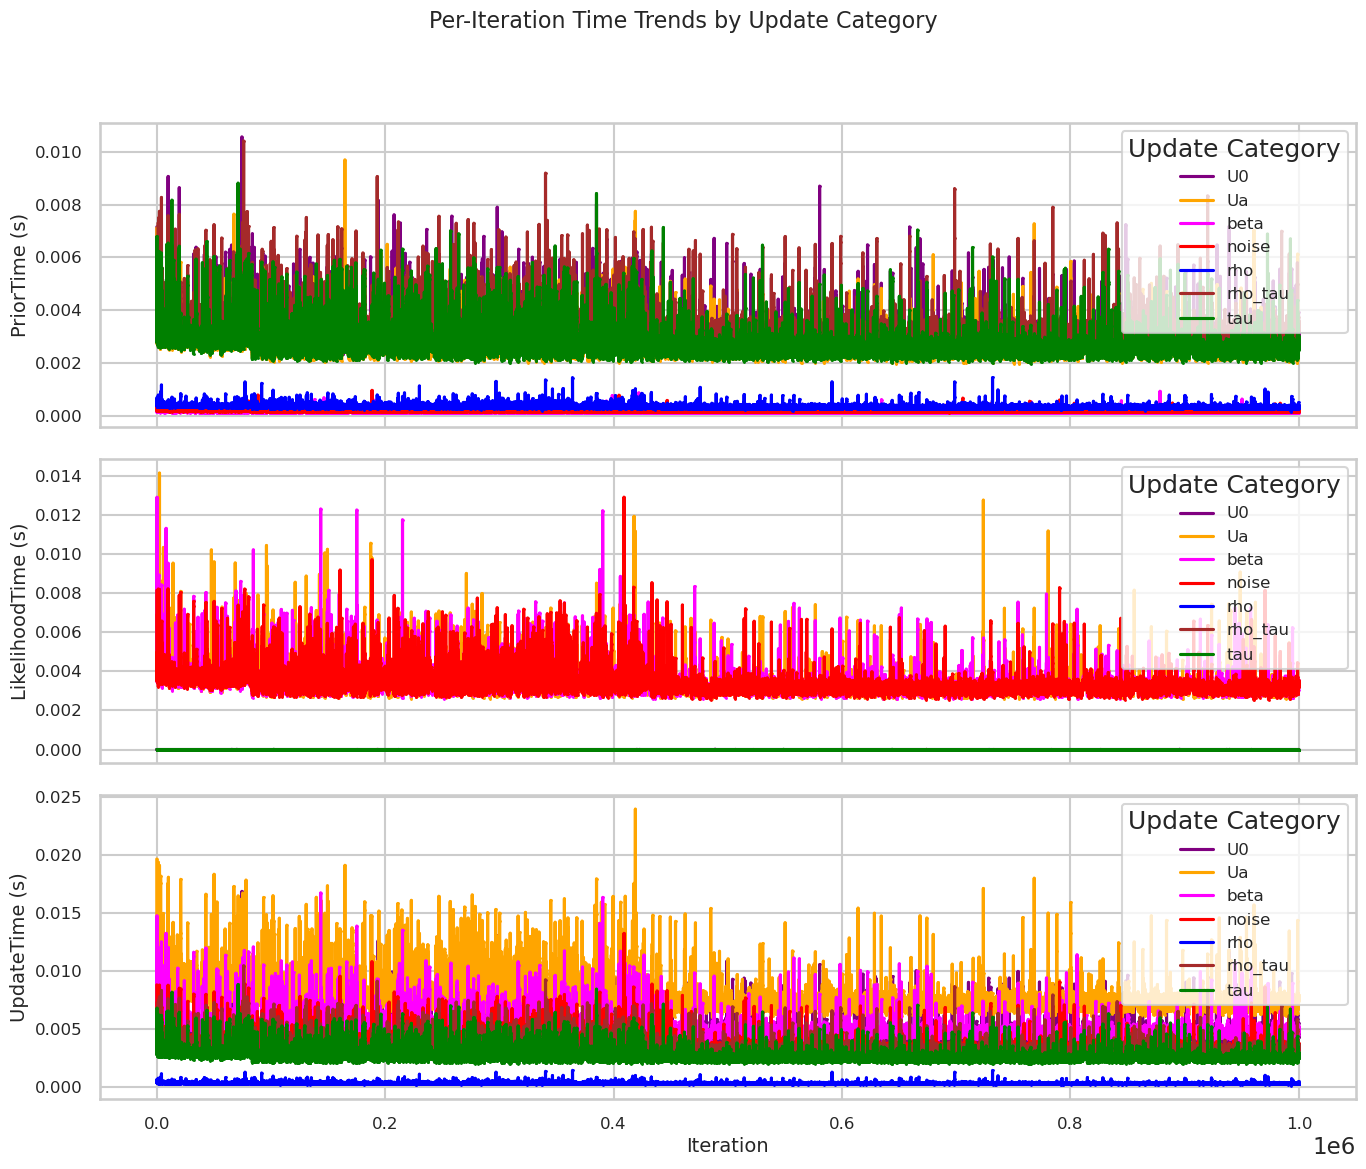

<Figure size 1000x600 with 0 Axes>

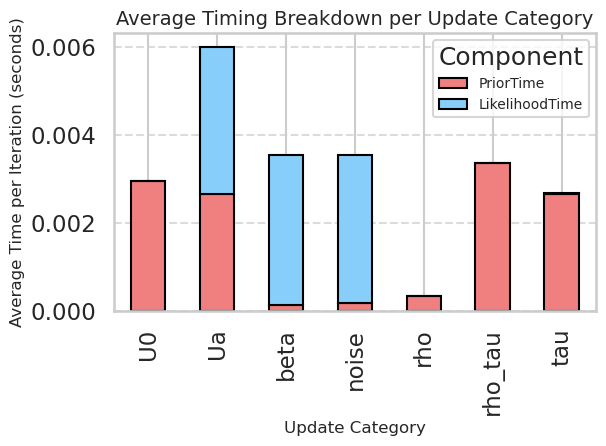

In [18]:
PO_plot.plot_time_components_by_category(mcmc_df)

### The posterior analysis of the HPO model

1. we plot the posterior distribution of the parameters, it should be close to its true value we inilised when construncting the partial order 
2. We test the U0 and Ua based on the following crieteria:
    - U0: 
        1. U0(i,k) and U0(j,k) have the covariance of 0
        2. U0(i,k) and U0(i,k') have the covariance of rho 
        3. The expected value of U0(i,k) for all i and k should be 0
    - Ua: The difference between Ua and U0*tau should be normally distributed with N(0, tau^2)

[INFO] Saved inferred parameters plot to './mcmc_inferred_result.pdf'


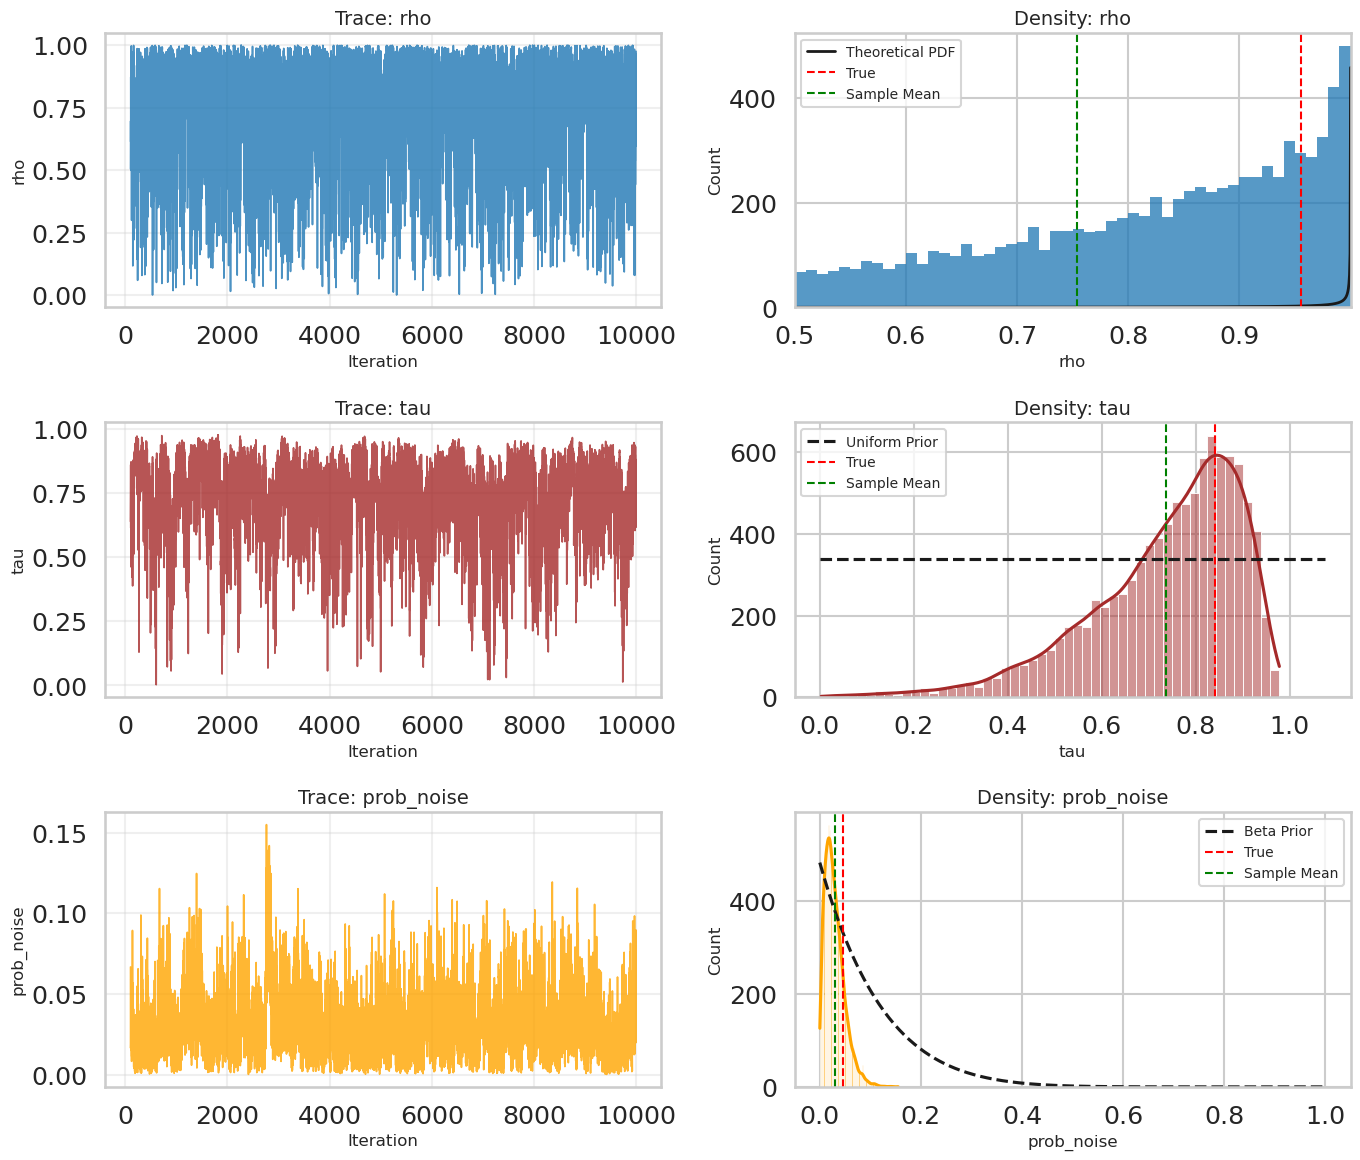

[INFO] Saved beta coefficient 0 plot to './beta_0_plot.pdf'


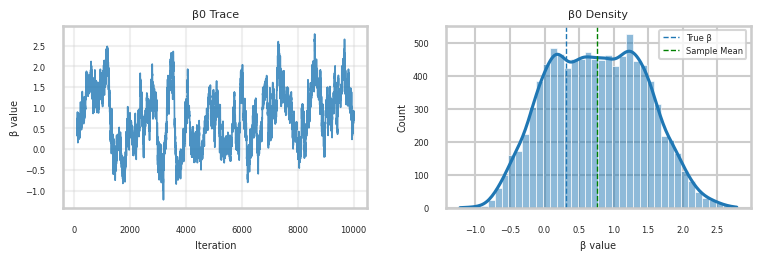

[INFO] Saved beta coefficient 1 plot to './beta_1_plot.pdf'


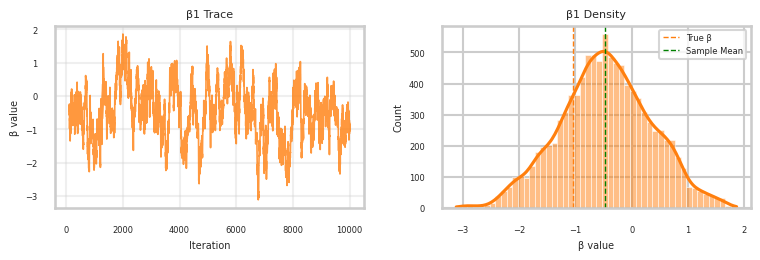

[INFO] Saved beta coefficient 2 plot to './beta_2_plot.pdf'


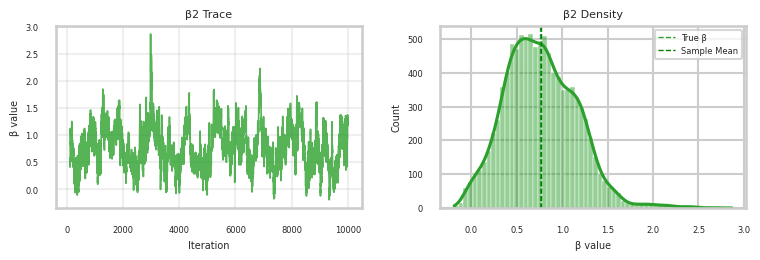

[INFO] Saved beta coefficient 3 plot to './beta_3_plot.pdf'


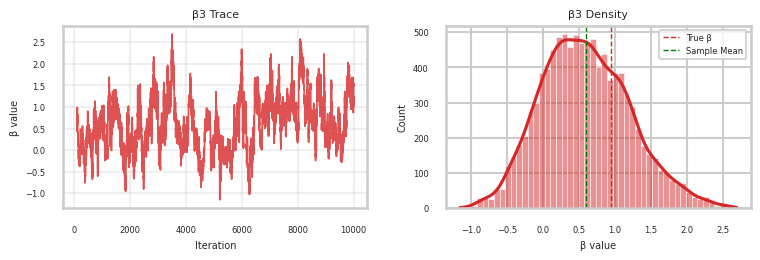

[INFO] Saved beta coefficient 4 plot to './beta_4_plot.pdf'


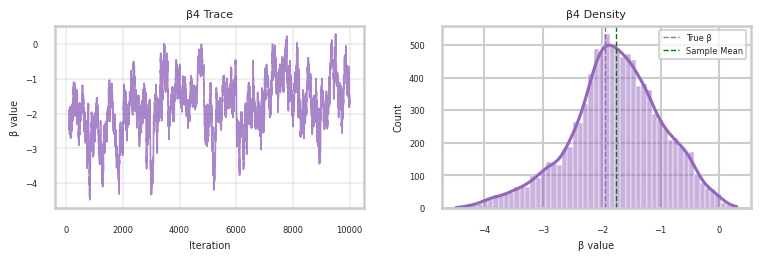

In [19]:
true_param = {
    "rho_true": rho_true,
    "prob_noise_true": prob_noise_true,
    "tau_true": tau_true,
    "beta_true": beta_true
}

PO_plot.plot_inferred_variables(
    filtered_mcmc_results,
    true_param,
    config,
    burn_in=burn_in,  # optional
    output_filename="mcmc_inferred_result.pdf",
    assessors=assessors,
    M_a_dict=M_a_dict  
)

PO_plot.plot_beta_parameters(mcmc_results, true_param, config, burn_in=burn_in)

### plot for the U matrix 

[U0] Total samples: 60000 | K = 3


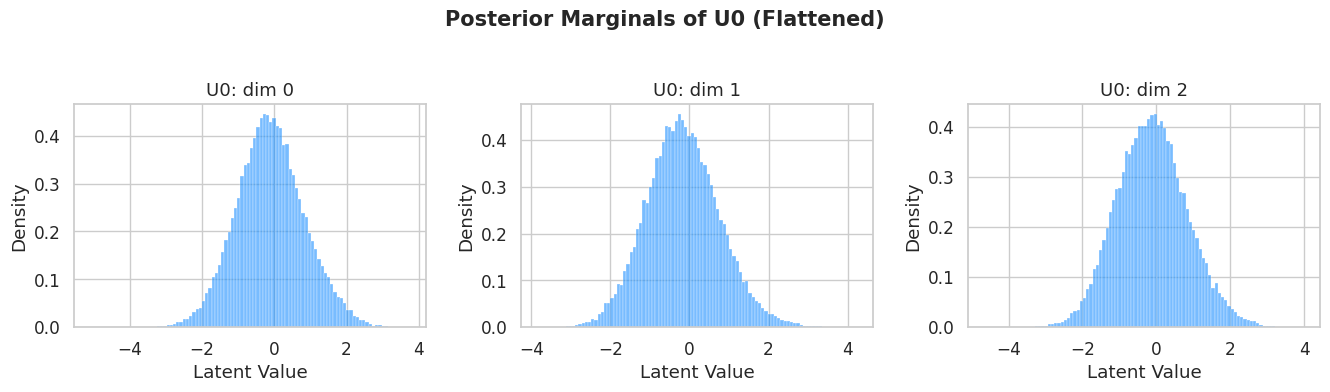

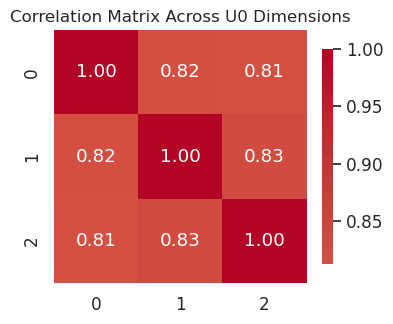

[Ua] Assessor 1: 20000 total rows.


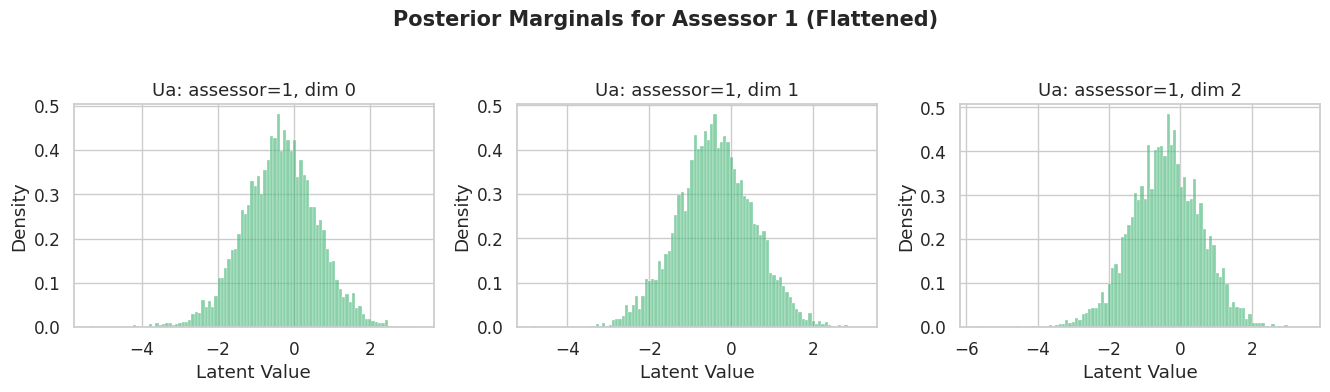

[Ua] Assessor 2: 60000 total rows.


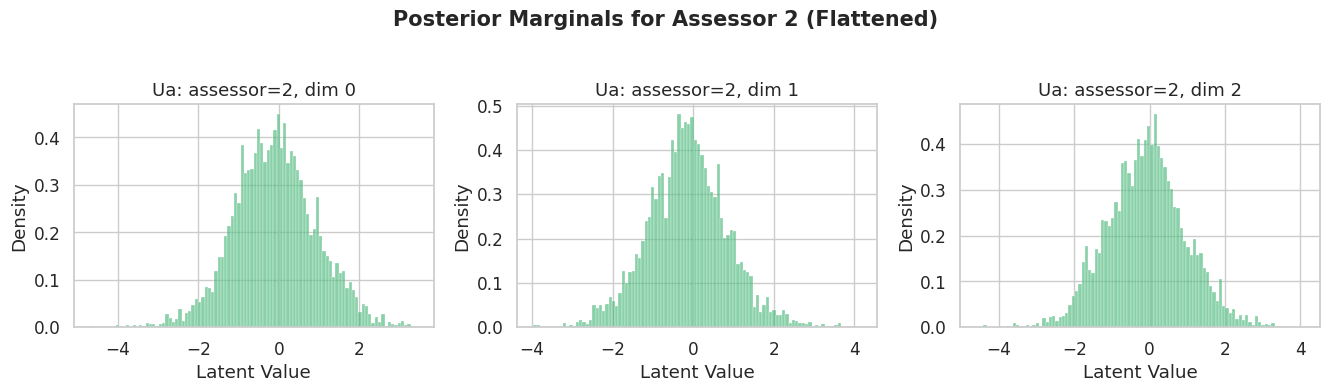

[Ua] Assessor 3: 30000 total rows.


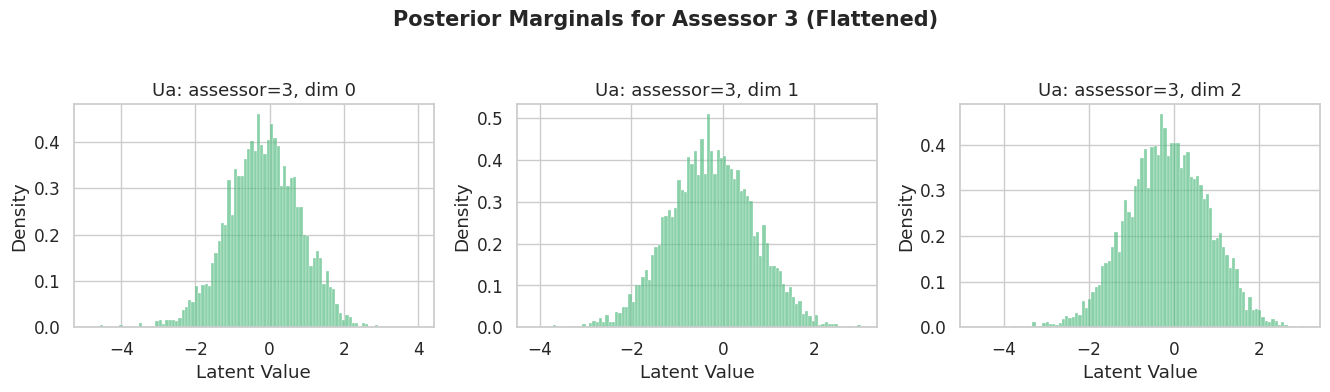

[Ua] Assessor 4: 50000 total rows.


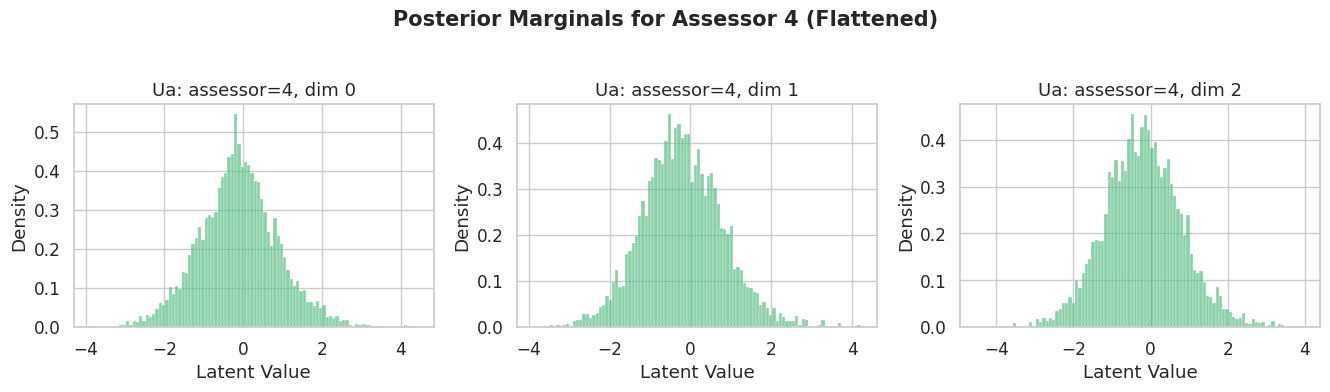

[Ua] Assessor 5: 30000 total rows.


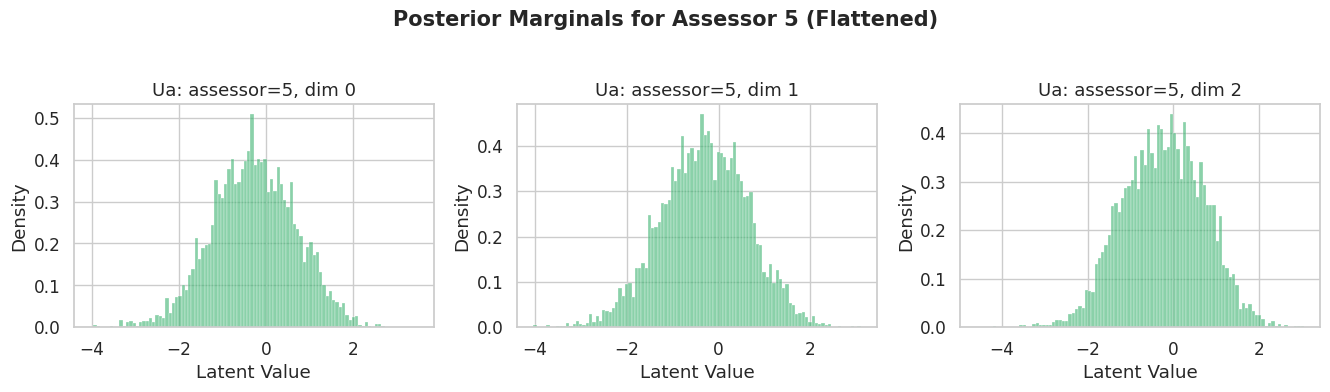

In [20]:
#FOr k in different dimension, this function is not working 
PO_plot.plot_u0_ua_diagnostics(
    results=filtered_mcmc_results,
    assessors=assessors,
    M0=items,
    K=K
)


## We compare the true result with the inferred result 


No missing relationships in global partial order.

No redundant relationships in global partial order.

==== Compare & Visualize Partial Order for Assessor 1 ====

No missing edges for assessor 1.

No redundant edges for assessor 1.

==== Compare & Visualize Partial Order for Assessor 2 ====

Missing edges for assessor 2:
4 < 3

No redundant edges for assessor 2.

==== Compare & Visualize Partial Order for Assessor 3 ====

No missing edges for assessor 3.

No redundant edges for assessor 3.

==== Compare & Visualize Partial Order for Assessor 4 ====

Missing edges for assessor 4:
5 < 1

No redundant edges for assessor 4.

==== Compare & Visualize Partial Order for Assessor 5 ====

No missing edges for assessor 5.

No redundant edges for assessor 5.


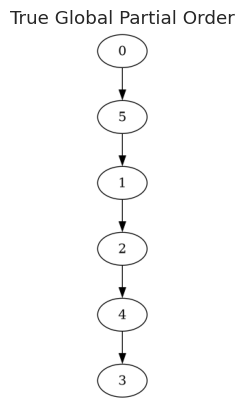

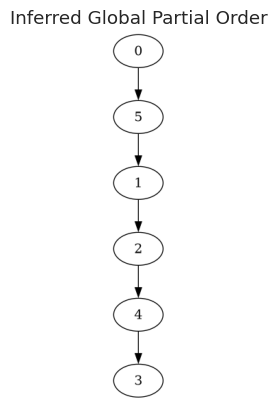

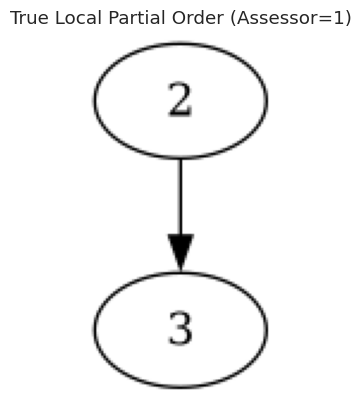

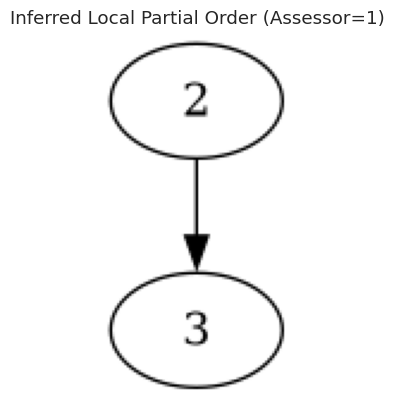

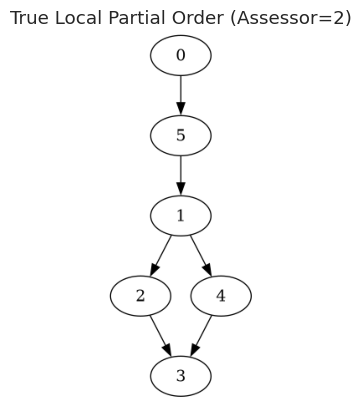

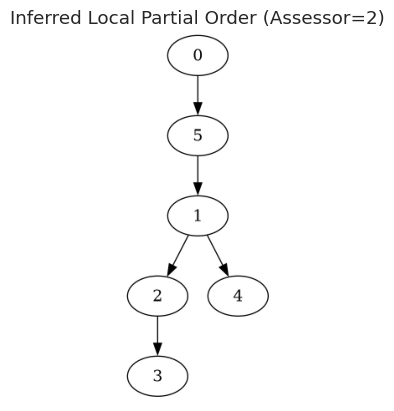

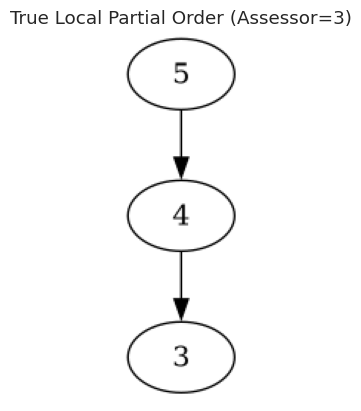

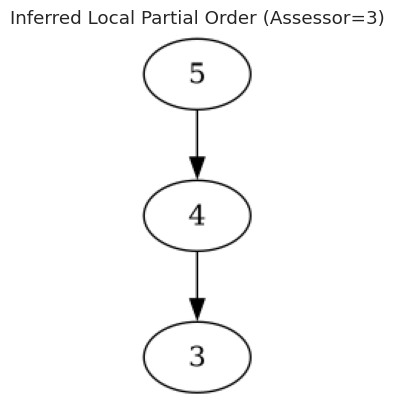

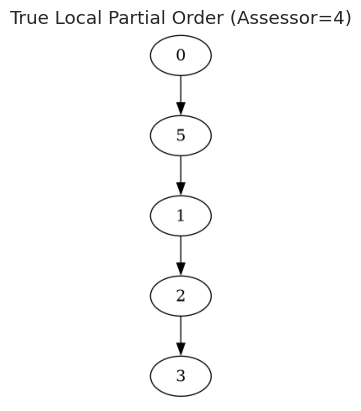

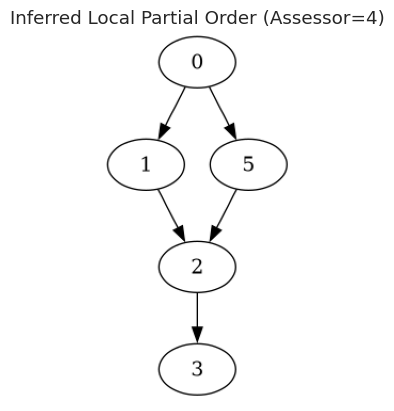

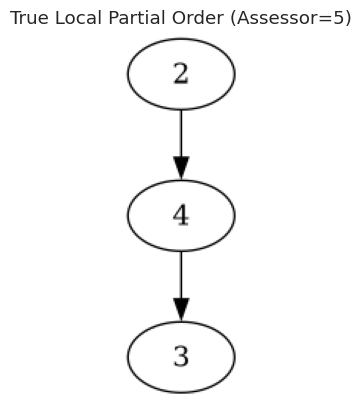

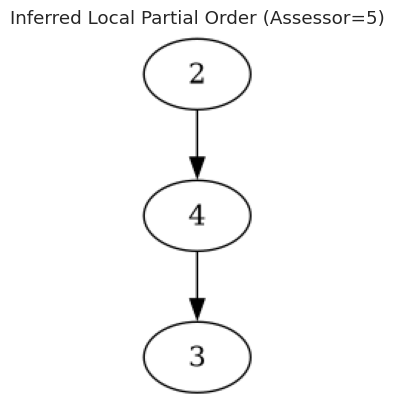

In [21]:

h_true_global = h_U_dict[0]
h_inferred_global = final_H[0]

# Build dictionaries for each assessor's adjacency matrices.
h_true_a_dict = {a: h_U_dict.get(a) for a in assessors}
h_inferred_a_dict = {a: final_H.get(a) for a in assessors}

global_Ma_list = [index_to_item[i] for i in sorted(index_to_item.keys())]

PO_plot.compare_and_visualize_global(
    h_true_global,
    h_inferred_global,
    index_to_item,
    global_Ma_list,
    do_transitive_reduction=True
)

for assessor in assessors:
    print(f"\n==== Compare & Visualize Partial Order for Assessor {assessor} ====")
    Ma_list_for_a = M_a_dict.get(assessor)
    PO_plot.compare_and_visualize_assessor(
        assessor,
        Ma_list_for_a,
        h_true_a_dict[assessor],
        h_inferred_a_dict[assessor],
        index_to_item_local_dict[assessor],
        do_transitive_reduction=True
    )



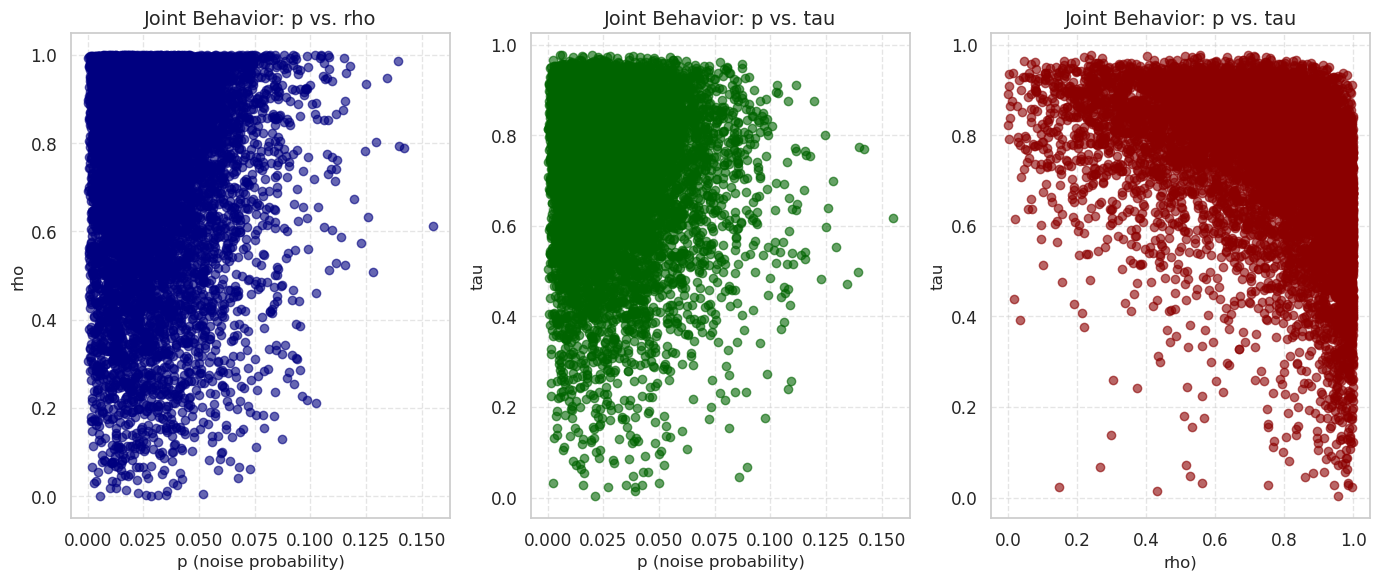

In [22]:

# Example usage:
# Assuming mcmc_results is the dictionary returned from mcmc_simulation_hpo:
PO_plot.plot_joint_parameters(mcmc_results)
